# **Khushdev Pandit**
# **Roll no: 2020211** 
# *Assignment Question-2*

In [ ]:
import os
from PIL import Image
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'white'
import torch.nn.functional as F
import cv2
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
import pickle
from sklearn import manifold
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report
from tqdm import tqdm

# **Q2 Part-1**

## **1(a)** *Download the training files. Use 20% of the training dataset for validation and 10% for testing. Initialize Weights & Biases (WandB).*

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 40.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.3/181.3 KB 22.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 19.2 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=03b6f056335dc64365b3270df22f108f973adc84f74ed1d4fb9f2389cc1fe105
  Stored in directory: /root/.cache/pip/wheels/4c/8e/7e/72fbc243e1aeecae64a96875432e70d4e92f3d2d18123be004
Successfully built pathtools
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [ ]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
path_data_img = "/content/drive/MyDrive/ECE344: CV (Computer Vision)/Assignments/Assignment-1/Q2/VOC Segmentation Dataset/images"
path_data_mask = "/content/drive/MyDrive/ECE344: CV (Computer Vision)/Assignments/Assignment-1/Q2/VOC Segmentation Dataset/masks"

img_path_list = os.listdir(path_data_img)
mask_path_list = os.listdir(path_data_mask)
img_path_list.sort()
mask_path_list.sort()
print("Number of images: ", len(img_path_list))
print("Number of masks: ", len(mask_path_list))

Number of images:  1464
Number of masks:  1464


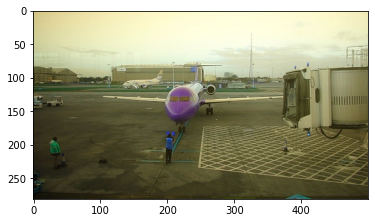

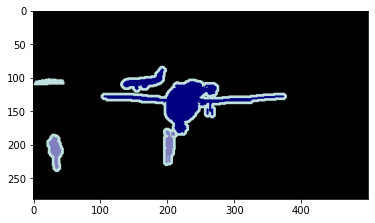

In [ ]:
img = cv2.imread(os.path.join(path_data_img, img_path_list[0])).astype(np.int64)
mask = cv2.imread(os.path.join(path_data_mask, mask_path_list[0])).astype(np.int64)
plt.imshow(img);
plt.show()
plt.imshow(mask);
plt.show()

In [ ]:
print('Shape of Image and Mask')
print(img.shape)
print(mask.shape)
print(mask[150,220])
np.unique(mask, return_counts=True)

Shape of Image and Mask
(281, 500, 3)
(281, 500, 3)
[  0   0 128]


(array([  0, 128, 192, 224]), array([398103,   6466,   6221,  10710]))

In [ ]:
# calculate the indices for the splits
total_images = len(img_path_list)
indices = np.arange(total_images)
val_split = int(0.2 * total_images)
test_split = int(0.1 * total_images)

# create the splits
train_images_index = indices[val_split+test_split:]
val_images_index = indices[:val_split]
test_images_index = indices[val_split:val_split+test_split]

print(len(train_images_index), len(val_images_index), len(test_images_index))

1026 292 146


## **1(b)** *Create dataloaders for all the splits (train, val and test) using Py-Torch to load the images and their corresponding segmentation masks.*

In [ ]:
class VOC2012Dataset(Dataset):
    def __init__(self, images, masks, img_indices, transform=None):
        self.img_indices = img_indices
        self.images = images
        self.masks = masks
        self.transform = transform

    def __len__(self):
        return len(self.img_indices)

    def __getitem__(self, idx, dontApplyTransform=False):
        img_name = self.images[self.img_indices[idx]]
        mask_name = self.masks[self.img_indices[idx]]
        img = cv2.imread(os.path.join(path_data_img, img_name)).astype(np.int32)
        mask = cv2.imread(os.path.join(path_data_mask, mask_name)).astype(np.int32)
        if self.transform and not dontApplyTransform:
            img = cv2.imread(os.path.join(path_data_img, img_name)).astype(np.float64) / 255
            mask = cv2.imread(os.path.join(path_data_mask, mask_name)).astype(np.float64) / 255
            img = self.transform(img)
            mask = self.transform(mask)
        return img, mask


# define the transforms
transform1 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
    # transforms.Resize((356, 356))
])
transform2 = transforms.Compose([
    transforms.ToTensor()]
)

# Datset for training, validation and testing
train_dataset = VOC2012Dataset(img_path_list, mask_path_list, train_images_index, transform=transform1)
val_dataset = VOC2012Dataset(img_path_list, mask_path_list, val_images_index, transform=transform1)
test_dataset = VOC2012Dataset(img_path_list, mask_path_list, test_images_index, transform=transform2)
print('Dataset lengths:', len(train_dataset), len(val_dataset), len(test_dataset))

# create the dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)
print('DataLoader lengths:', len(train_loader), len(val_loader), len(test_loader))

Dataset lengths: 1026 292 146
DataLoader lengths: 33 10 5


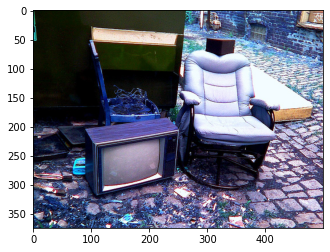

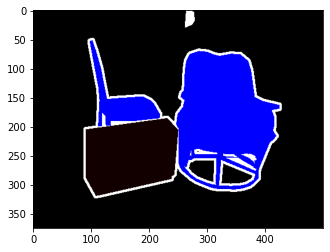


Labels/Masks size:
(375, 500, 3)
torch.Size([3, 375, 500])
torch.Size([375, 500, 3])
torch.Size([3, 375, 500])

Count of pixel values:
(array([  0,  64, 128, 192, 224], dtype=int32), array([469227,  16973,  16973,  41019,  18308]))
(array([-2.11790393, -2.03571429, -1.80444444, -0.91526611,  0.07406456,
        1.17004881,  1.54196078,  1.88585434,  2.09969499]), array([161373, 161373, 146481,  16973,  16973,   9154,  31865,   9154,
         9154]))


In [ ]:
plt.imshow(train_dataset.__getitem__(1, dontApplyTransform=True)[0]); plt.show()
plt.imshow(train_dataset.__getitem__(1)[1].permute(1,2,0)); plt.show()

print('\nLabels/Masks size:')
print(train_dataset.__getitem__(1, dontApplyTransform=True)[1].shape)
print(train_dataset.__getitem__(1)[0].shape)
print(train_dataset.__getitem__(1)[0].permute(1,2,0).shape)
print(train_dataset.__getitem__(1)[1].shape)

print('\nCount of pixel values:')
print(np.unique(train_dataset.__getitem__(1, dontApplyTransform=True)[1], return_counts=True))
print(np.unique(train_dataset.__getitem__(1)[1], return_counts=True))


## **1(c)** *Visualize the data distribution across class labels for training and validation sets.*

In [ ]:
class_pixels = np.array([[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                [0, 64, 128]])
class_pixels = np.array([pixel[::-1] for pixel in class_pixels])

class_labels = ['background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
                'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog',
                'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa',
                'train', 'tvmonitor']

(333, 500, 3) (333, 500, 3)


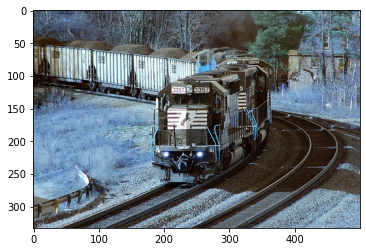

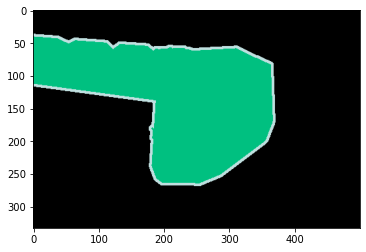

In [ ]:
img, mask = val_dataset.__getitem__(10, dontApplyTransform=True)
print(img.shape, mask.shape)
plt.imshow(img); plt.show()
plt.imshow(mask); plt.show()

In [ ]:
import seaborn as sns

# plot the class labels for Traininig and Validation dataset
def plot_class_labels(dataset:VOC2012Dataset, class_labels:list, class_pixels:list, set_name:str):
    num_classes = len(class_labels)
    dataset_labels_count = np.zeros((num_classes,), dtype=np.int64)

    for i in range(len(dataset)):
        img, mask = dataset.__getitem__(i, dontApplyTransform=True)
        
        # Count the number of pixels for each class in the current image
        label_pixel_cnt_img = np.zeros((num_classes,), dtype=np.int64)
        for j in range(num_classes):
            label_pixel_cnt_img[j] += np.sum(np.all(mask==class_pixels[j], axis=-1))
        
        # If the current image has pixels for a class, increment the count for that class in the dataset
        for j in range(num_classes):
            dataset_labels_count[j] += 1 if label_pixel_cnt_img[j] > 0 else 0
    
    plt.figure(figsize=(10, 5))
    plt.bar(class_labels, dataset_labels_count)
    plt.xticks(rotation=90)
    for index, value in enumerate(dataset_labels_count):
        plt.text(index, value, str(value), va='bottom', )
    plt.xlabel('Class Labels')
    plt.ylabel('Number of Total Classes in dataset')
    plt.title(f'Data distribution across class labels for {set_name} Dataset')
    plt.show()
    
    return dataset_labels_count

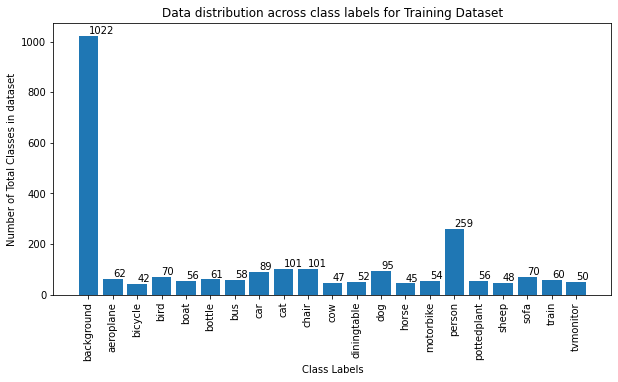

[1022   62   42   70   56   61   58   89  101  101   47   52   95   45
   54  259   56   48   70   60   50]


In [ ]:
train_dataset_labels_count = plot_class_labels(train_dataset, class_labels, class_pixels, 'Training')
print(train_dataset_labels_count)

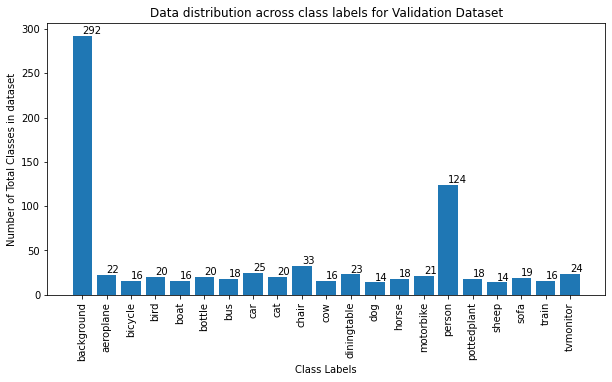

[292  22  16  20  16  20  18  25  20  33  16  23  14  18  21 124  18  14
  19  16  24]


In [ ]:
val_dataset_labels_count = plot_class_labels(val_dataset, class_labels, class_pixels, 'Validation')
print(val_dataset_labels_count)

# **Q2 Part-2** *Fine-tune a segmentation model*

## **2(a)** *Train fcn resnet50 model using pre-defined network weights using an appropriate loss function. Use wandb for logging the loss and accuracy.*

In [ ]:
wandb.init(entity="cv_assignment", project="Assignment-1",name="Q2-Part2")
wandb.config = {"learning_rate": 0.001, "epochs": 10, "batch_size": 16}  

wandb: Currently logged in as: khushdev20211 (cv_assignment). Use `wandb login --relogin` to force relogin


In [ ]:
transform  = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        transforms.Resize((128, 128))
])

# Datset for training, validation and testing
train_dataset = VOC2012Dataset(img_path_list, mask_path_list, train_images_index, transform=transform)
val_dataset = VOC2012Dataset(img_path_list, mask_path_list, val_images_index, transform=transform)
test_dataset = VOC2012Dataset(img_path_list, mask_path_list, test_images_index, transform=transform)
print('Dataset lengths:', len(train_dataset), len(val_dataset), len(test_dataset))

# create the dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)
print('DataLoader lengths:', len(train_loader), len(val_loader), len(test_loader))

Dataset lengths: 1026 292 146
DataLoader lengths: 65 19 10


In [ ]:
import torch.optim as optim
from torchvision.models.segmentation import FCN_ResNet50_Weights

# Define the FCN resnet50 model
model = models.segmentation.fcn_resnet50(weights=FCN_ResNet50_Weights.DEFAULT)

# Define the loss function (cross-entropy loss) and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3)

Downloading: "https://download.pytorch.org/models/fcn_resnet50_coco-1167a1af.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet50_coco-1167a1af.pth


  0%|          | 0.00/135M [00:00<?, ?B/s]

In [ ]:
epochs = 3
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print('Training on:', device)

for epoch in range(epochs):
    print('\nEpoch:', epoch)
    # =========================================== Training Phase =============================================
    model.train()
    train_loss = 0        # Training loss
    correct_pixels = 0    # Number of pixels correctly predicted
    total_pixels = 0      # Total number of pixels in the training set
    for image, mask in tqdm(train_loader):
        image = image.to(device)
        mask = mask.to(device)
        mask = torch.mean(mask, dim=1, keepdim=True)
        image = image.type(torch.cuda.FloatTensor)
        mask = mask.type(torch.cuda.FloatTensor)
        optimizer.zero_grad()
        outputs = model(image)['out']
        loss = criterion(outputs, mask.argmax(dim=1))
        loss.backward()
        optimizer.step()

        # calculate training loss
        train_loss += loss.item()
        # calculate training accuracy
        predicted_mask = torch.argmax(outputs, dim=1)
        correct_pixels += torch.sum(predicted_mask == mask.argmax(dim=1)).item()
        total_pixels += torch.numel(predicted_mask)
        batch_accuracy = correct_pixels / total_pixels
    training_accuracy = 100 * correct_pixels / total_pixels

    # =========================================== Validation Phase ========================================
    model.eval()
    with torch.no_grad():
      # Validation loss
      valid_loss = 0        # Training loss
      correct_pixels = 0    # Number of pixels correctly predicted
      total_pixels = 0      # Total number of pixels in the validation set
      for image, mask in tqdm(val_loader):
          image = image.to(device)
          mask = mask.to(device)
          mask = torch.mean(mask, dim=1, keepdim=True)
          image = image.type(torch.cuda.FloatTensor)
          mask = mask.type(torch.cuda.FloatTensor)
          outputs = model(image)['out']
          loss = criterion(outputs, mask.argmax(dim=1))

          # calculate training loss
          valid_loss += loss.item()
          # calculate training accuracy
          predicted_mask = torch.argmax(outputs, dim=1)
          correct_pixels += torch.sum(predicted_mask == mask.argmax(dim=1)).item()
          total_pixels += torch.numel(predicted_mask)
          batch_accuracy = correct_pixels / total_pixels
      valid_accuracy = 100 * correct_pixels / total_pixels
    
    print("\nTraining Loss: {:.4f},  Training Accuracy: {:.4f}".format(train_loss / len(train_loader), training_accuracy))
    print("Validation Loss: {:.4f},  Validation Accuracy: {:.4f}".format(valid_loss / len(val_loader), valid_accuracy))
    # Log the loss and accuracy to W&B
    wandb.log({'training_loss': train_loss / len(train_loader), 'validation_loss': valid_loss / len(val_loader),
               'training_accuracy': training_accuracy, 'validation_accuracy': valid_accuracy})

print('Finished Training')

Training on: cuda:0

Epoch: 0


100%|██████████| 19/19 [02:42<00:00,  8.54s/it]



Training Loss: 0.0108,  Training Accuracy: 99.8127
Validation Loss: 0.0013,  Validation Accuracy: 100.0000

Epoch: 1


100%|██████████| 19/19 [00:09<00:00,  2.07it/s]



Training Loss: 0.0009,  Training Accuracy: 100.0000
Validation Loss: 0.0031,  Validation Accuracy: 100.0000

Epoch: 2


100%|██████████| 19/19 [00:08<00:00,  2.32it/s]


Training Loss: 0.0011,  Training Accuracy: 100.0000
Validation Loss: 0.0054,  Validation Accuracy: 100.0000
Finished Training


In [ ]:
# ✨ W&B: Save Model
torch.save(model, 'fcs_resnet50_q2_b.pt')
torch.save(model.state_dict(),"fcs_resnet50_q2_b.pth")
artifact = wandb.Artifact('model', type='model')
artifact.add_file('fcs_resnet50_q2_b.pt')
artifact.add_file('fcs_resnet50_q2_b.pth')
wandb.log_artifact(artifact)
wandb.finish()

training_accuracy,▁██
training_loss,█▁▁
validation_accuracy,▁▁▁
validation_loss,▁▄█
training_accuracy,100.0
training_loss,0.00108
validation_accuracy,100.0
validation_loss,0.00544


In [ ]:
import pickle
with open('fcs_resnet50_model.pickle', 'wb') as f:
  pickle.dump(model, f)

with open('fcs_resnet50_model.pickle', 'rb') as pickle_in:
    fcs_resnet50 = pickle.load(pickle_in)

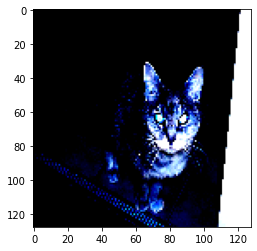

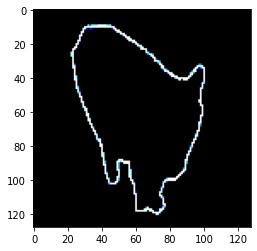

In [ ]:
img, mask = train_loader.dataset.__getitem__(0)
plt.imshow(img.permute(1,2,0)); plt.show()
plt.imshow(mask.permute(1,2,0)); plt.show()

torch.Size([16, 3, 128, 128]) torch.Size([16, 128, 128]) torch.Size([16, 21, 128, 128]) torch.Size([16, 128, 128])



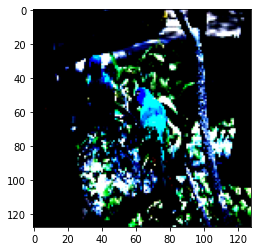

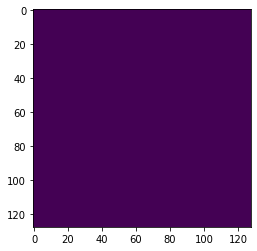

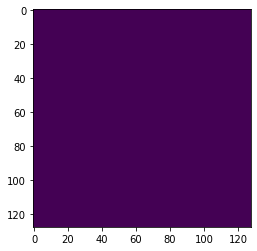

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

for i, batch in enumerate(train_loader, 0):
        if i == 1: break
        image, mask = batch
        image = image.to(device)
        mask = mask.to(device)
        image = image.type(torch.cuda.FloatTensor)
        mask = mask.type(torch.cuda.FloatTensor)
        mask = torch.argmax(mask, dim=1)
        outputs = model(image.to(device))['out']
        predicted_mask = torch.argmax(outputs, dim=1)
        print(image.shape, mask.shape, outputs.shape, predicted_mask.shape)
        print()

index = 11
plt.imshow(image.cpu()[index].permute(1,2,0)); plt.show()
plt.imshow(mask.cpu()[index]); plt.show();
plt.imshow(predicted_mask.cpu()[index]); plt.show();

## **2(b)** *(6 points) Report the classwise performance of the test set in terms of pixel-wise accuracy, F1-Score and IoU (Intersection Over Union). Also report precision, recall and average precision (AP). Use the IoUs within range [0, 1] with 0.1 interval size for computation of the above metrics. You may refer to this article to learn more about the evaluation of segmentation models. Include all your findings in the submitted report.*

In [ ]:
import pickle
with open('/content/drive/MyDrive/fcs_resnet50_model.pickle', 'rb') as pickle_in:
    model = pickle.load(pickle_in)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, average_precision_score, jaccard_score, precision_recall_fscore_support
import numpy as np
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

def calculate_metrics_for_class(class_idx):
    # class_idx  ->  index of the class to evaluate
    threshold = 0.5  # probability threshold for binarizing the output mask
    model.eval()
    y_true = []  # true segmentation masks
    y_pred = []  # predicted segmentation masks

    with torch.no_grad():
      valid_loss = 0        # Training loss
      correct_pixels = 0    # Number of pixels correctly predicted
      total_pixels = 0      # Total number of pixels in the validation set
      for image, mask in tqdm(val_loader):
          image = image.to(device)
          mask = mask.to(device)
          mask = torch.mean(mask, dim=1, keepdim=True)
          image = image.type(torch.cuda.FloatTensor)
          mask = mask.type(torch.cuda.FloatTensor)
          outputs = model(image)['out']
          loss = criterion(outputs, mask.argmax(dim=1))

          # calculate training loss
          valid_loss += loss.item()
          # calculate training accuracy
          predicted_mask = torch.argmax(outputs, dim=1)
          correct_pixels += torch.sum(predicted_mask == mask.argmax(dim=1)).item()
          total_pixels += torch.numel(predicted_mask)
          batch_accuracy = correct_pixels / total_pixels
      valid_accuracy = 100 * correct_pixels / total_pixels

    # Flatten the arrays
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    # Calculate the metrics
    accuracy = accuracy_score(y_true.ravel(), y_pred.ravel())
    f1 = f1_score(y_true.ravel(), y_pred.ravel())
    precision = precision_score(y_true.ravel(), y_pred.ravel())
    recall = recall_score(y_true.ravel(), y_pred.ravel())
    average_precision = average_precision_score(y_true.ravel(), y_pred.ravel())
    iou = jaccard_score(y_true.ravel(), y_pred.ravel())
    return accuracy, f1, precision, recall, average_precision, iou


classwise_metrics = {}
num_classes = 21

for class_idx in range(num_classes):
    # Calculate the metrics for the current class
    accuracy, f1, precision, recall, average_precision, iou = calculate_metrics_for_class(class_idx)

    # Store the metrics in a dictionary
    classwise_metrics[class_labels[class_idx]] = {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'average_precision': average_precision,
        'iou': iou
    }

print(classwise_metrics)

 21%|██        | 4/19 [01:28<05:31, 22.09s/it]


KeyboardInterrupt: ignored

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, average_precision_score, jaccard_score, precision_recall_fscore_support
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

threshold = 0.5  # probability threshold for binarizing the output mask
class_idx = 0
model.eval()
y_true = []  # true segmentation masks
y_pred = []  # predicted segmentation mask

with torch.no_grad():
    test_accuracy = 0
    correct_pixels = 0
    total_pixels = 0
    for image, mask in tqdm(val_loader):
        image = image.to(device)
        mask = mask.to(device)
        mask = torch.mean(mask, dim=1, keepdim=True)
        image = image.type(torch.cuda.FloatTensor)
        mask = mask.type(torch.cuda.FloatTensor)
        outputs = model(image)['out']
        loss = criterion(outputs, mask.argmax(dim=1))

        # calculate testing accuracy
        predicted_mask = torch.argmax(outputs, dim=1)
        correct_pixels += torch.sum(predicted_mask == mask.argmax(dim=1)).item()
        total_pixels += torch.numel(predicted_mask)
        batch_accuracy = correct_pixels / total_pixels

        y_pred.append(predicted_mask.cpu().numpy())
        y_true.append(mask.cpu().numpy())
    
    test_accuracy = 100 * correct_pixels / total_pixels

print('Testing Accuracy:', test_accuracy)

y_true = np.concatenate(y_true, axis=0)
y_pred = np.concatenate(y_pred, axis=0)
y_true = y_true == class_idx 
y_pred = y_pred == class_idx 

# Calculate the metrics
accuracy = accuracy_score(y_true.flatten(), y_pred.flatten())
f1 = f1_score(y_true.flatten(), y_pred.flatten(), zero_division=0)
precision = precision_score(y_true.flatten(), y_pred.flatten(), zero_division=0)
recall = recall_score(y_true.flatten(), y_pred.flatten(), zero_division=0)
average_precision = average_precision_score(y_true.flatten(), y_pred.flatten())
iou = jaccard_score(y_true.flatten(), y_pred.flatten())

f1, precision, recall, average_precision, iou

100%|██████████| 19/19 [00:11<00:00,  1.65it/s]


Testing Accuracy: 100.0


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


(0.0, 0.0, 0.0, nan, 0.0)

In [ ]:
print(y_true.ravel())
print(y_pred.ravel())
print(y_true.ravel().shape)
print(y_pred.ravel().shape)
print(np.unique(y_pred.ravel()).max())

[-2.117904 -2.117904 -2.117904 ... -2.117904 -2.117904 -2.117904]
[1 1 1 ... 1 1 1]
(2392064,)
(2392064,)
1


# **Q2 Part-3** *Data augmentation techniques*

## **3(a)** *Use any 2 (or more) Data Augmentation techniques that are suitable for this problem. Remember that data augmentation techniques are used for synthetically adding more training data so that the model can train on more variety of data samples.*

In [ ]:
class VOC2012Dataset(Dataset):
    def __init__(self, images, masks, img_indices, transform1=None, transform2=None):
        self.img_indices = img_indices
        self.images = images
        self.masks = masks
        self.transform1 = transform1
        self.transform2 = transform2

    def __len__(self):
        return len(self.img_indices)

    def __getitem__(self, idx, dontApplyTransform=False):
        img_name = self.images[self.img_indices[idx]]
        mask_name = self.masks[self.img_indices[idx]]
        img = cv2.imread(os.path.join(path_data_img, img_name)).astype(np.float32) / 255
        mask = cv2.imread(os.path.join(path_data_mask, mask_name)).astype(np.float32) / 255
        if self.transform1 and np.random.choice(2, 1) == 1:
            img = self.transform1(img)
            mask = self.transform1(mask)
        else:
            img = self.transform2(img)
            mask = self.transform2(mask)
        return img, mask

transform1 = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    transforms.Resize((128, 128))]
)
transform2 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    transforms.Resize((128, 128))]
)

# Datset for training, validation and testing
train_dataset = VOC2012Dataset(img_path_list, mask_path_list, train_images_index, transform1=transform1, transform2=transform2)
val_dataset = VOC2012Dataset(img_path_list, mask_path_list, val_images_index, transform1=transform1, transform2=transform2)
test_dataset = VOC2012Dataset(img_path_list, mask_path_list, test_images_index, transform1=None, transform2=transform2)
print('Dataset lengths:', len(train_dataset), len(val_dataset), len(test_dataset))

# create the dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)
print('DataLoader lengths:', len(train_loader), len(val_loader), len(test_loader))

Dataset lengths: 1026 292 146
DataLoader lengths: 65 19 10


## **3(b)** *(4 points) Follow the same steps as in Question 2.2.(a) to train the model.*

In [ ]:
wandb.init(entity="cv_assignment", project="Assignment-1",name="Q2-Part3")
wandb.config = {"learning_rate": 0.001, "epochs": 10, "batch_size": 16}  

wandb: Currently logged in as: khushdev20211 (cv_assignment). Use `wandb login --relogin` to force relogin


In [ ]:
import torch.optim as optim
from torchvision.models.segmentation import FCN_ResNet50_Weights

# Define the FCN resnet50 model
model = models.segmentation.fcn_resnet50(weights=FCN_ResNet50_Weights.DEFAULT)

# Define the loss function (cross-entropy loss) and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3)

Downloading: "https://download.pytorch.org/models/fcn_resnet50_coco-1167a1af.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet50_coco-1167a1af.pth


  0%|          | 0.00/135M [00:00<?, ?B/s]

In [ ]:
epochs = 3
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print('Training on:', device)

for epoch in range(epochs):
    print('\nEpoch:', epoch)
    # =========================================== Training Phase =============================================
    model.train()
    train_loss = 0        # Training loss
    correct_pixels = 0    # Number of pixels correctly predicted
    total_pixels = 0      # Total number of pixels in the training set
    for image, mask in tqdm(train_loader):
        image = image.to(device)
        mask = mask.to(device)
        mask = torch.mean(mask, dim=1, keepdim=True)
        image = image.type(torch.cuda.FloatTensor)
        mask = mask.type(torch.cuda.FloatTensor)
        optimizer.zero_grad()
        outputs = model(image)['out']
        loss = criterion(outputs, mask.argmax(dim=1))
        loss.backward()
        optimizer.step()

        # calculate training loss
        train_loss += loss.item()
        # calculate training accuracy
        predicted_mask = torch.argmax(outputs, dim=1)
        correct_pixels += torch.sum(predicted_mask == mask.argmax(dim=1)).item()
        total_pixels += torch.numel(predicted_mask)
        batch_accuracy = correct_pixels / total_pixels
    training_accuracy = 100 * correct_pixels / total_pixels

    # =========================================== Validation Phase ========================================
    model.eval()
    with torch.no_grad():
      # Validation loss
      valid_loss = 0        # Training loss
      correct_pixels = 0    # Number of pixels correctly predicted
      total_pixels = 0      # Total number of pixels in the validation set
      for image, mask in tqdm(val_loader):
          image = image.to(device)
          mask = mask.to(device)
          mask = torch.mean(mask, dim=1, keepdim=True)
          image = image.type(torch.cuda.FloatTensor)
          mask = mask.type(torch.cuda.FloatTensor)
          outputs = model(image)['out']
          loss = criterion(outputs, mask.argmax(dim=1))

          # calculate training loss
          valid_loss += loss.item()
          # calculate training accuracy
          predicted_mask = torch.argmax(outputs, dim=1)
          correct_pixels += torch.sum(predicted_mask == mask.argmax(dim=1)).item()
          total_pixels += torch.numel(predicted_mask)
          batch_accuracy = correct_pixels / total_pixels
      valid_accuracy = 100 * correct_pixels / total_pixels
    
    print("\nTraining Loss: {:.4f},  Training Accuracy: {:.4f}".format(train_loss / len(train_loader), training_accuracy))
    print("Validation Loss: {:.4f},  Validation Accuracy: {:.4f}".format(valid_loss / len(val_loader), valid_accuracy))
    # Log the loss and accuracy to W&B
    wandb.log({'training_loss': train_loss / len(train_loader), 'validation_loss': valid_loss / len(val_loader),
               'training_accuracy': training_accuracy, 'validation_accuracy': valid_accuracy})

print('Finished Training')

Training on: cuda:0

Epoch: 0


100%|██████████| 19/19 [02:22<00:00,  7.51s/it]



Training Loss: 0.0145,  Training Accuracy: 99.6894
Validation Loss: 0.0016,  Validation Accuracy: 100.0000

Epoch: 1


100%|██████████| 19/19 [00:17<00:00,  1.06it/s]



Training Loss: 0.0013,  Training Accuracy: 100.0000
Validation Loss: 0.0021,  Validation Accuracy: 100.0000

Epoch: 2


100%|██████████| 19/19 [00:21<00:00,  1.15s/it]


Training Loss: 0.0013,  Training Accuracy: 100.0000
Validation Loss: 0.0012,  Validation Accuracy: 100.0000
Finished Training


In [ ]:
# ✨ W&B: Save Model
torch.save(model, 'fcs_resnet50_q2_c.pt')
torch.save(model.state_dict(),"fcs_resnet50_q2_c.pth")
artifact = wandb.Artifact('model', type='model')
artifact.add_file('fcs_resnet50_q2_c.pt')
artifact.add_file('fcs_resnet50_q2_c.pth')
wandb.log_artifact(artifact)
wandb.finish()

In [ ]:
import pickle
with open('fcs_resnet50_aug_model.pickle', 'wb') as f:
  pickle.dump(model, f)

with open('fcs_resnet50_aug_model.pickle', 'rb') as pickle_in:
    fcs_resnet50 = pickle.load(pickle_in)